#libs

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
pip install hyperopt

In [ ]:
pip install bayesian-optimization

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.0 MB/s eta 0:00:00


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.ensemble import  GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score, max_error
from yellowbrick.regressor import ResidualsPlot



from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer

#data

In [ ]:
df=pd.read_excel('data-final.xlsx',sheet_name='paper1')

In [ ]:
# Separate features (X) and target variable (y)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
X.drop(['Urbach_energy','PL_relative_intensity_1', 'PL_relative_intensity_2','drop-mg'],axis=1,inplace=True)

##split and scale data

In [ ]:
#split and scale data
def split_and_scale_data(x, y, test_size=0.2, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

#feature_importances

In [ ]:
def get_feature_importances(model, X):

    importances = model.feature_importances_
    importance_scores = list(zip(X.columns, importances))
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    importance_df = pd.DataFrame(importance_scores, columns=['Feature', 'Importance'])

    return importance_df

#shap value plots

In [ ]:
def plot_shap_values(model,X, X_train, X_test):
    """
    Calculate and plot SHAP values for both train and test sets.

    Parameters:
    - model: The trained model to explain.
    - X: The feature matrix.
    - X_train: Training data (features).
    - X_test: Testing data (features).
    """
    explainer = shap.Explainer(model, feature_names=X.columns)
    shap_values_train = explainer(X_train)
    shap_values_test = explainer(X_test)

    # Plot SHAP summary plot for test set
    shap.summary_plot(shap_values_test, X_test, feature_names=X.columns, show=False, plot_size=[8, 6])
    plt.title('SHAP Values (Test Set)')
    plt.show()
    # Plot SHAP summary plot for train set
    shap.summary_plot(shap_values_train, X_train, feature_names=X.columns, show=False, plot_size=[8, 6])
    plt.title('SHAP Values (Train Set)')
    plt.show()



    # Plot SHAP bar plot for test set (local)
    plt.title('SHAP Values Local bar plot (Test Set)')
    shap.plots.bar(shap_values_test[0], max_display=26)
    plt.show()
    # Plot SHAP bar plot for train set (local)
    plt.title('SHAP Values Local bar plot (Train Set)')
    shap.plots.bar(shap_values_train[0], max_display=26)
    plt.show()



    # Plot SHAP bar plot for test set (global)
    plt.title('SHAP Values Global bar plot (Test Set)')
    shap.plots.bar(shap_values_test, max_display=26)
    plt.show()

    # Plot SHAP bar plot for train set (global)
    plt.title('SHAP Values Global bar plot (Train Set)')
    shap.plots.bar(shap_values_train, max_display=26)
    plt.show()

#⏩️ X1 Drop (1-6)

In [ ]:
X_train, X_test, y_train, y_test = split_and_scale_data(X, y, test_size=0.2, random_state=78)

##Xgboost

In [ ]:
# Define the XGBoost model
def xgboost_model(random_seed=78):
    return XGBRegressor(random_state=random_seed, verbosity=0)

# Define the parameter space
param_space = {
    'learning_rate': (0.01, 0.09, 'uniform'),
    'max_depth': (3, 15),
    'reg_lambda': (0.0, 5.0, 'uniform'),

    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'subsample': (0.6, 1.0, 'uniform'),
    'n_estimators': (100, 1000) }

# Set up BayesSearchCV
optimizer = BayesSearchCV(
    xgboost_model(),
    param_space,
    n_iter=5,
    random_state=78,
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Perform optimization
optimizer.fit(X_train, y_train)

# Get the best parameters
best_params = optimizer.best_params_

# Train the best model
best_model = xgboost_model().set_params(**best_params)
best_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

# Predictions on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculate R2 scores
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# Calculate Adjusted R2 scores
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p)

n_test = len(y_test)
n_train = len(y_train)
p = 26  # number of features
adj_r2_test = adjusted_r2(r2_test, n_test, p)
adj_r2_train = adjusted_r2(r2_train, n_train, p)

# Results DataFrame
xgb = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_test],
    'R-squared Score (Train Set)': [r2_train],
    'Adjusted R-squared Score (Test Set)': [adj_r2_test],
    'Adjusted R-squared Score (Train Set)': [adj_r2_train],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'MAE (Test Set)': [mean_absolute_error(y_test, y_pred_test)],
    'MAE (Train Set)': [mean_absolute_error(y_train, y_pred_train)],
    'Explained Variance Score (Test Set)': [explained_variance_score(y_test, y_pred_test)],
    'Explained Variance Score (Train Set)': [explained_variance_score(y_train, y_pred_train)],
    'Max Error (Test Set)': [max_error(y_test, y_pred_test)],
    'Max Error (Train Set)': [max_error(y_train, y_pred_train)],
    'Best max_depth': [best_params['max_depth']],
    'Best learning_rate': [best_params['learning_rate']],
    'Best n_estimators': [best_params['n_estimators']],
    'Best subsample': [best_params['subsample']],
    'Best reg_lambda': [best_params['reg_lambda']],
    'Best colsample_bytree': [best_params['colsample_bytree']],
    'Cross-Validation Mean R2': [np.mean(cv_scores)],
    'Cross-Validation Std R2': [np.std(cv_scores)]
}, index=['XGBoost-Bayesian Optimization'])


# Print individual CV scores
print("\nCross-Validation R2 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

(xgb)


Cross-Validation R2 Scores:
Fold 1: 0.5068
Fold 2: -0.1882
Fold 3: -0.0008
Fold 4: -0.7942
Fold 5: 0.0990


,R-squared Score (Test Set),R-squared Score (Train Set),Adjusted R-squared Score (Test Set),Adjusted R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),MAE (Test Set),MAE (Train Set),Explained Variance Score (Test Set),Explained Variance Score (Train Set),Max Error (Test Set),Max Error (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best reg_lambda,Best colsample_bytree,Cross-Validation Mean R2,Cross-Validation Std R2
XGBoost-Bayesian Optimization,0.840445,0.899388,1.039889,1.402449,0.28379,0.218485,0.227486,0.183127,0.846174,0.899389,0.514223,0.412684,12,0.014697,619,0.734916,3.566077,0.514327,-0.075475,0.425294


In [ ]:
feature_importances = get_feature_importances(best_model, X)
(feature_importances)

,Feature,Importance
0,FWHM3,0.172787
1,rel_int5,0.094957
2,FWHM6,0.083436
3,FWHM1,0.076708
4,FWHM2,0.074355
5,FWHM5,0.068036
6,rel_int1,0.064899
7,FWHM4,0.046392
8,PL_fwhm_1,0.037905
9,Drop,0.029241


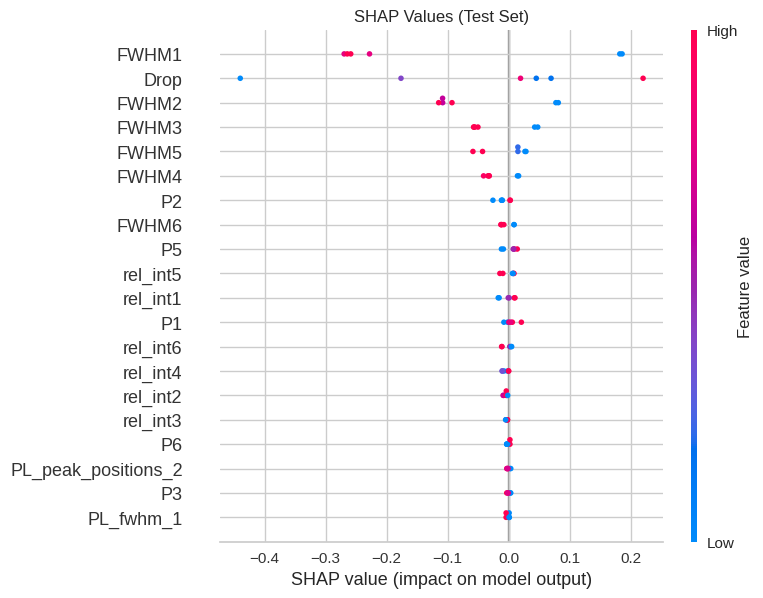

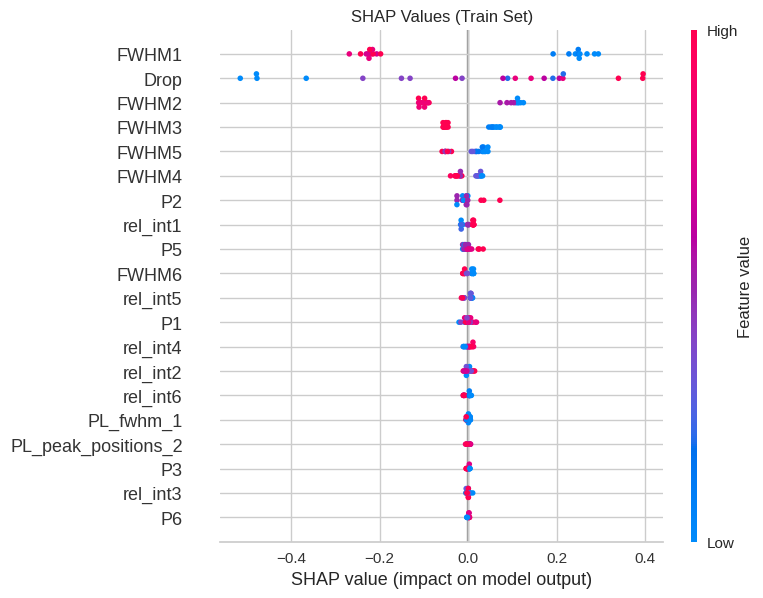

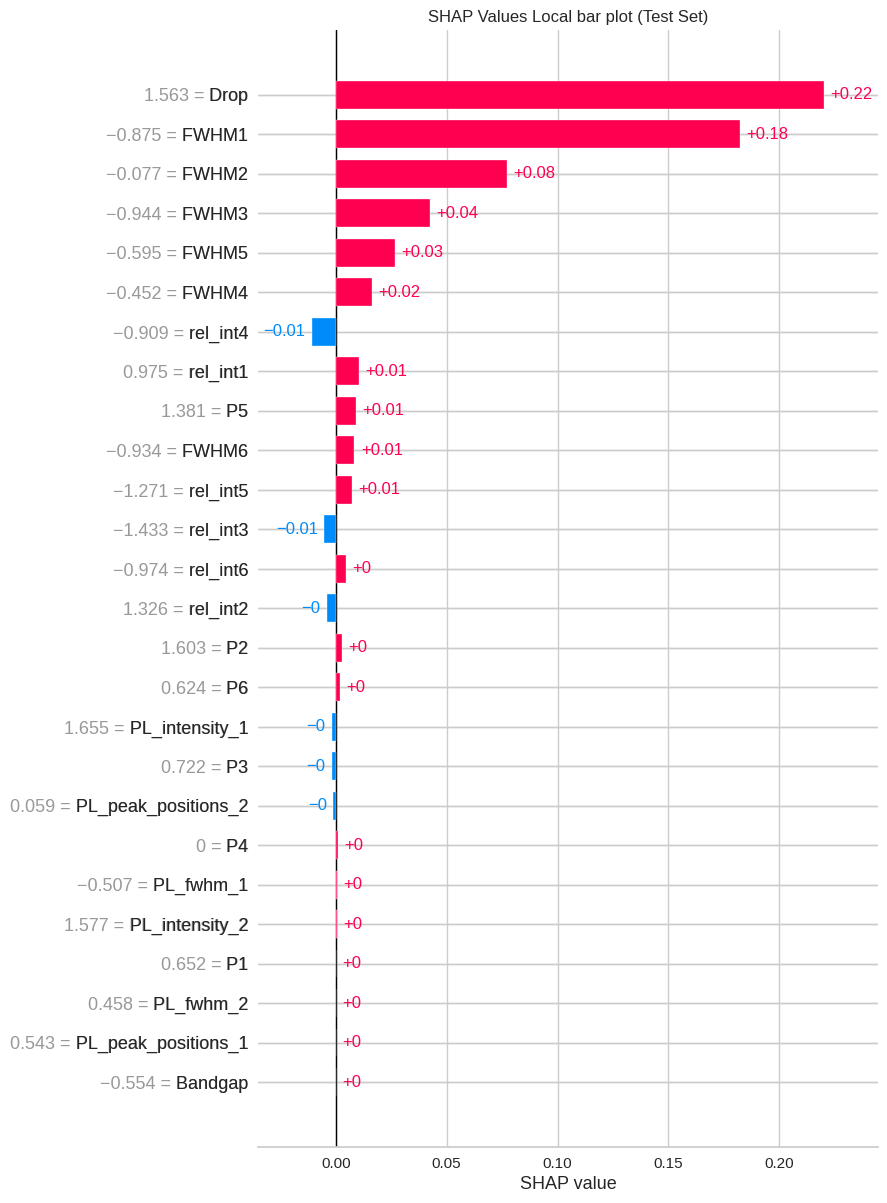

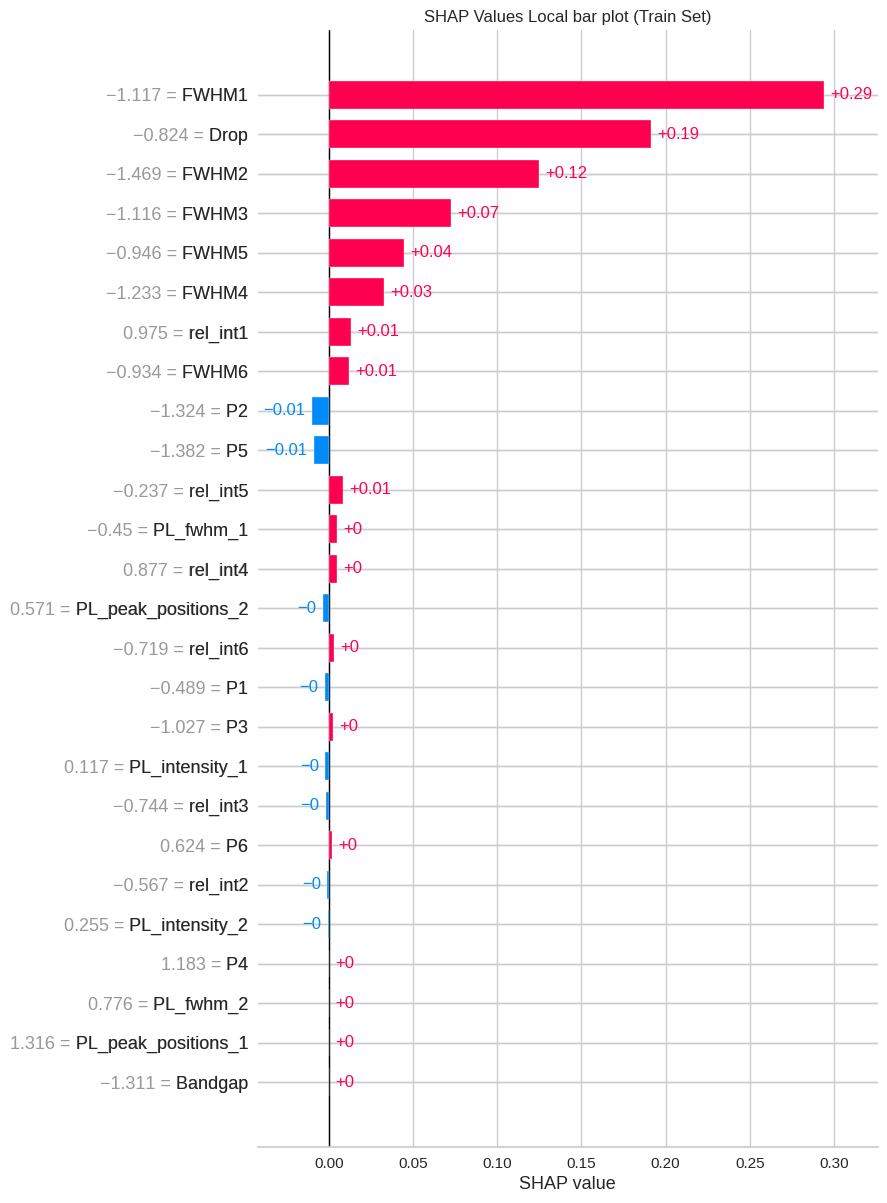

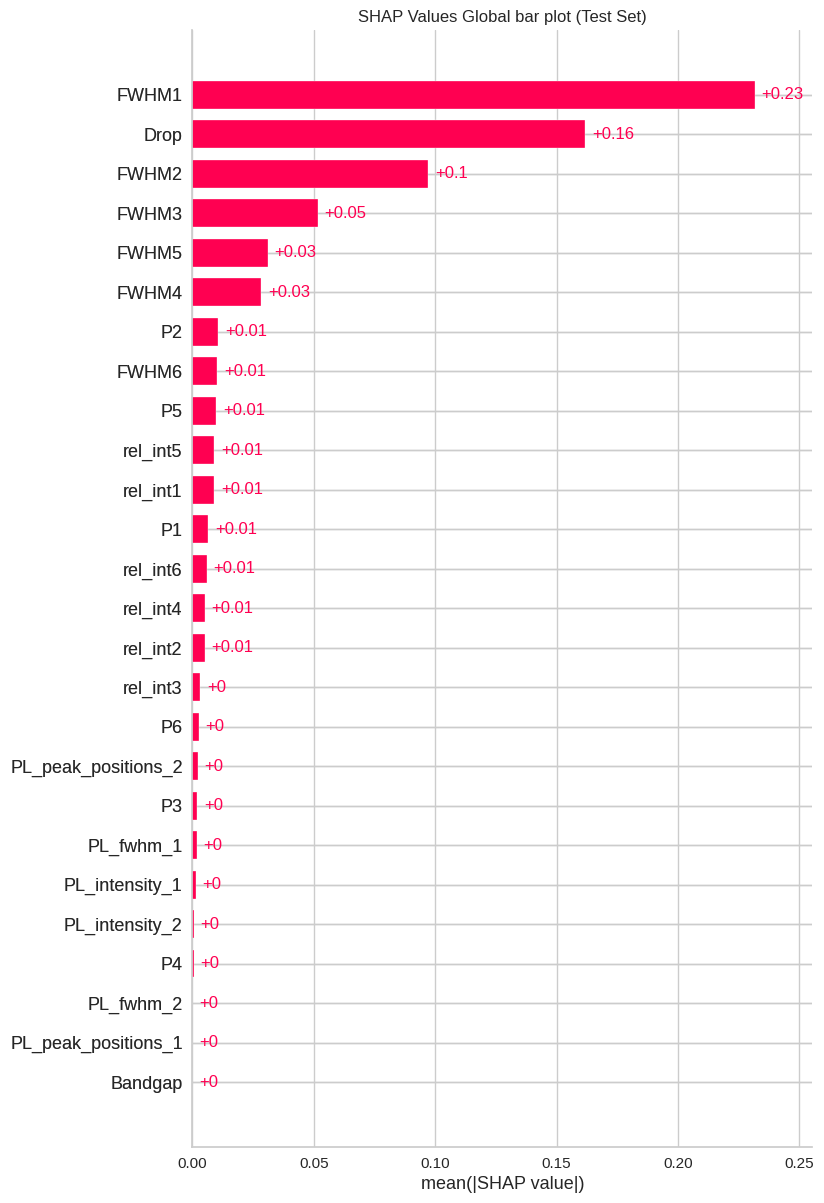

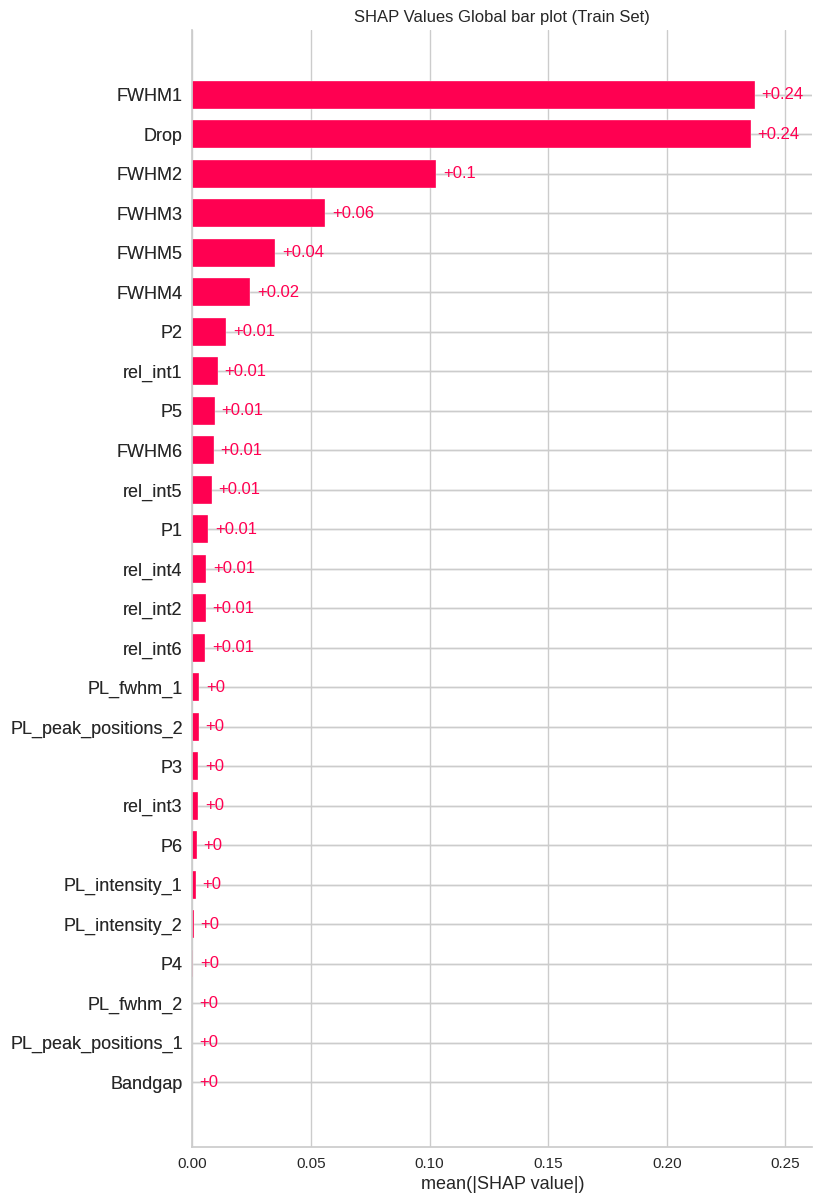

In [ ]:
shap_values = plot_shap_values(best_model, X, X_train, X_test)

##Catboost skopt.BayesSearchCV

In [ ]:
# Define the catboost model
def catboost_model(random_seed=78):
    return CatBoostRegressor(random_seed=random_seed, verbose=False)

# Define the parameter space
param_space = {
    'learning_rate': (0.01, 0.09, 'uniform'),
    'depth': (3, 15),
    'l2_leaf_reg': (0.0, 3.0, 'uniform'),
    'rsm': (0.5, 1.0, 'uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'iterations': (100, 1000),
}

# Set up BayesSearchCV
optimizer = BayesSearchCV(
    catboost_model(),
    param_space,
    n_iter=5,
    random_state=78,
    cv=5,
    n_jobs=-1,
    verbose=0)

# Perform optimization
optimizer.fit(X_train, y_train)

# Get the best parameters
best_params = optimizer.best_params_

# Train the best model
best_model = catboost_model().set_params(**best_params)
best_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

# Predictions on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


# Calculate R2 scores
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# Calculate Adjusted R2 scores
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p)

n_test = len(y_test)
n_train = len(y_train)
p = 26 # number of features
adj_r2_test = adjusted_r2(r2_test, n_test, p)
adj_r2_train = adjusted_r2(r2_train, n_train, p)

# Results DataFrame
cat = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_test],
    'R-squared Score (Train Set)': [r2_train],
    'Adjusted R-squared Score (Test Set)': [adj_r2_test],
    'Adjusted R-squared Score (Train Set)': [adj_r2_train],
    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'MAE (Test Set)': [mean_absolute_error(y_test, y_pred_test)],
    'MAE (Train Set)': [mean_absolute_error(y_train, y_pred_train)],
    'Explained Variance Score (Test Set)': [explained_variance_score(y_test, y_pred_test)],
    'Explained Variance Score (Train Set)': [explained_variance_score(y_train, y_pred_train)],
    'Max Error (Test Set)': [max_error(y_test, y_pred_test)],
    'Max Error (Train Set)': [max_error(y_train, y_pred_train)],
    'Best depth': [best_params['depth']],
    'Best learning_rate': [best_params['learning_rate']],
    'Best iterations': [best_params['iterations']],
    'Best subsample': [best_params['subsample']],
    'Best l2_leaf_reg': [best_params['l2_leaf_reg']],
    'Best rsm': [best_params['rsm']],
    'Cross-Validation Mean R2': [np.mean(cv_scores)],
    'Cross-Validation Std R2': [np.std(cv_scores)]
}, index=['CatBoost-Bayesian Optimization'])



# Print individual CV scores
print("\nCross-Validation R2 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

cat


Cross-Validation R2 Scores:
Fold 1: 0.4501
Fold 2: -0.0288
Fold 3: 0.0013
Fold 4: -0.6253
Fold 5: 0.0321


,R-squared Score (Test Set),R-squared Score (Train Set),Adjusted R-squared Score (Test Set),Adjusted R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),MAE (Test Set),MAE (Train Set),Explained Variance Score (Test Set),Explained Variance Score (Train Set),Max Error (Test Set),Max Error (Train Set),Best depth,Best learning_rate,Best iterations,Best subsample,Best l2_leaf_reg,Best rsm,Cross-Validation Mean R2,Cross-Validation Std R2
CatBoost-Bayesian Optimization,0.834707,0.874831,1.041323,1.500678,0.288848,0.243694,0.237032,0.201567,0.837214,0.874832,0.549881,0.45619,3,0.056166,153,0.668644,2.330655,0.856608,-0.034125,0.343431


In [ ]:
feature_importances = get_feature_importances(best_model, X)
feature_importances

,Feature,Importance
0,Drop,33.249492
1,rel_int1,12.683497
2,PL_peak_positions_1,6.014098
3,PL_intensity_2,5.606401
4,rel_int3,4.410783
5,PL_fwhm_2,4.241983
6,FWHM3,4.169368
7,Bandgap,3.902853
8,FWHM1,3.317066
9,FWHM2,3.193499


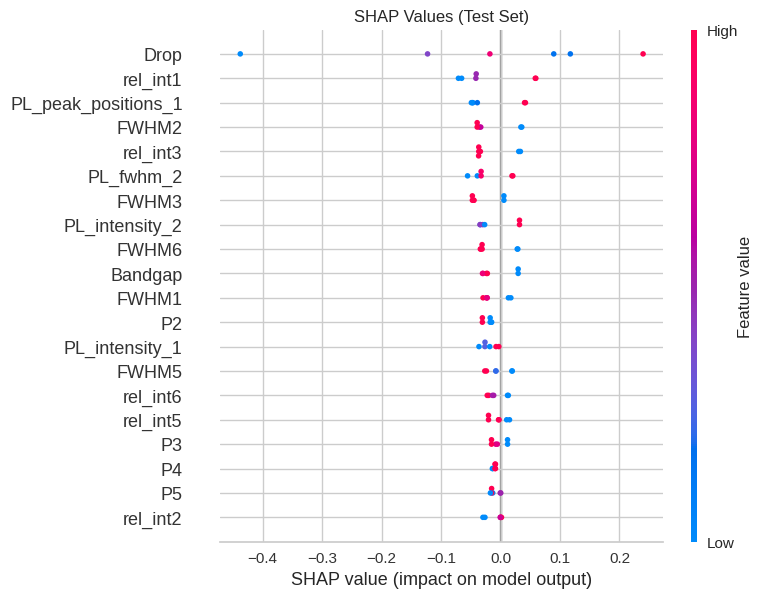

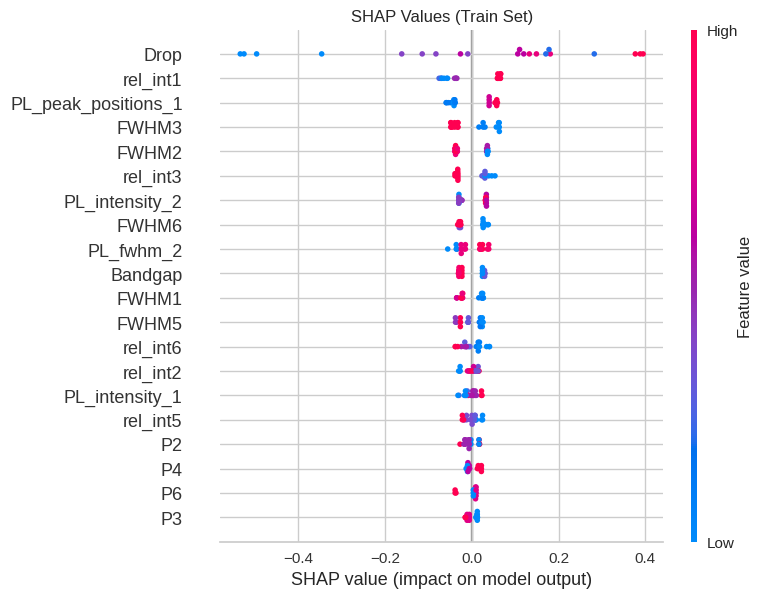

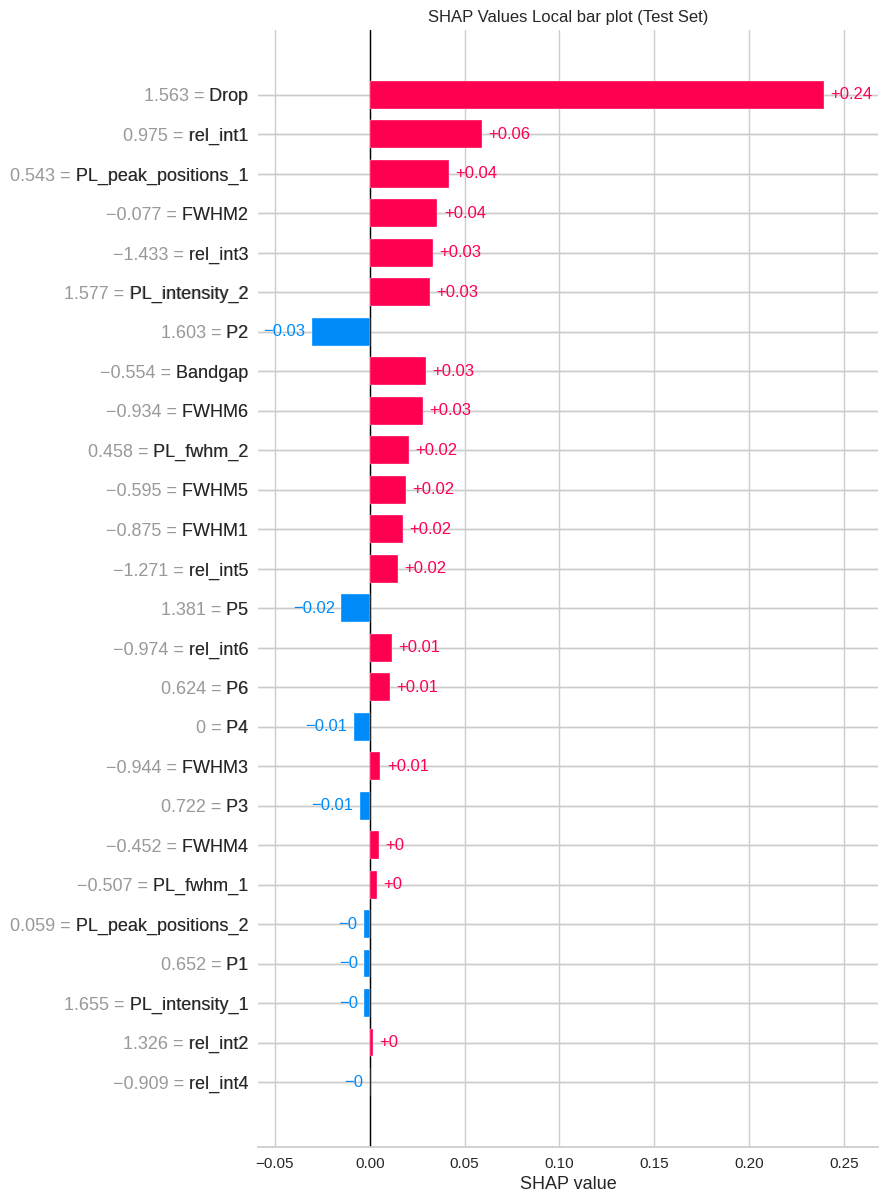

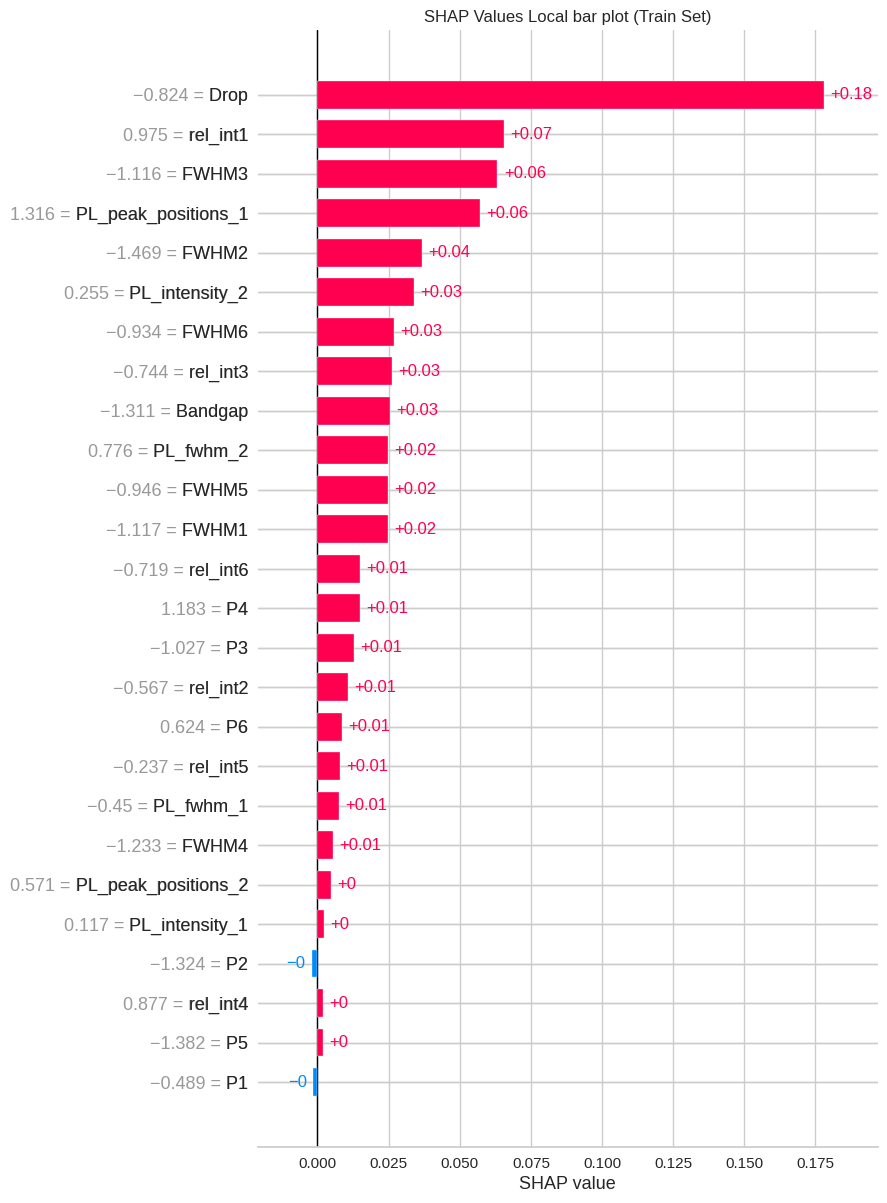

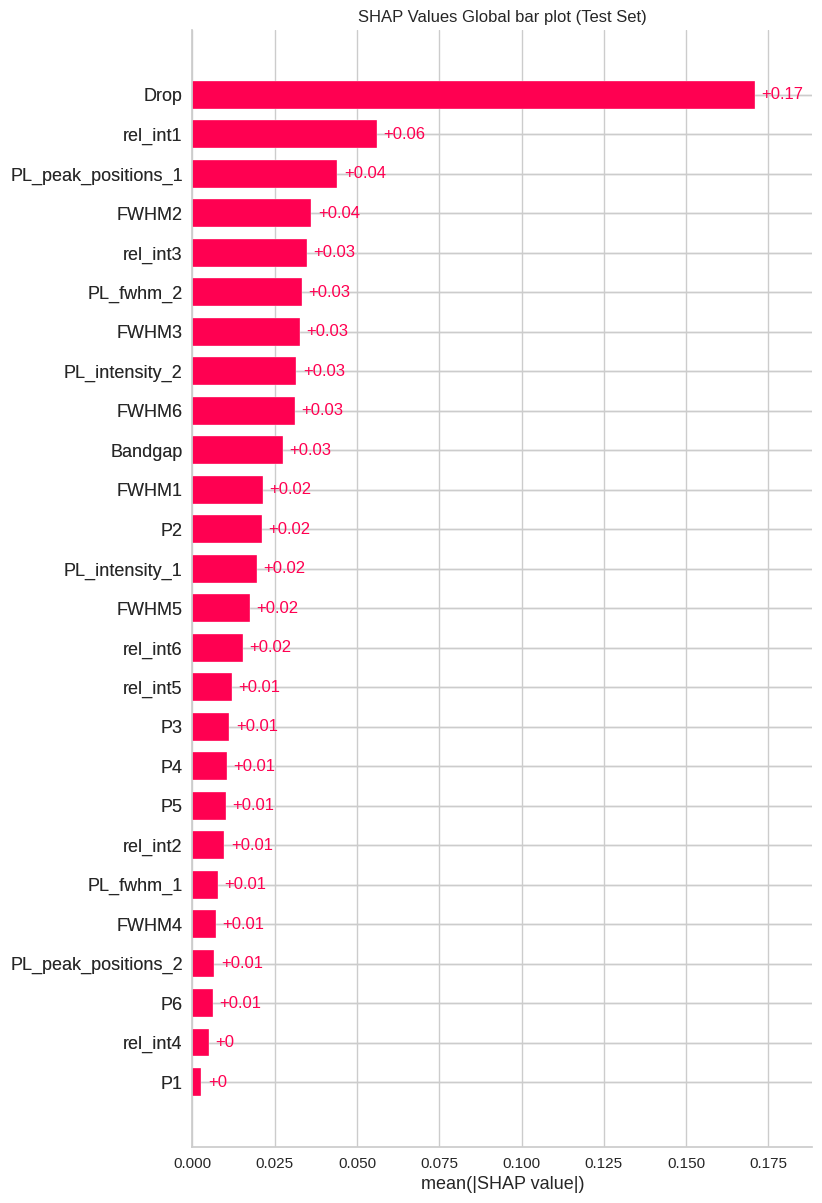

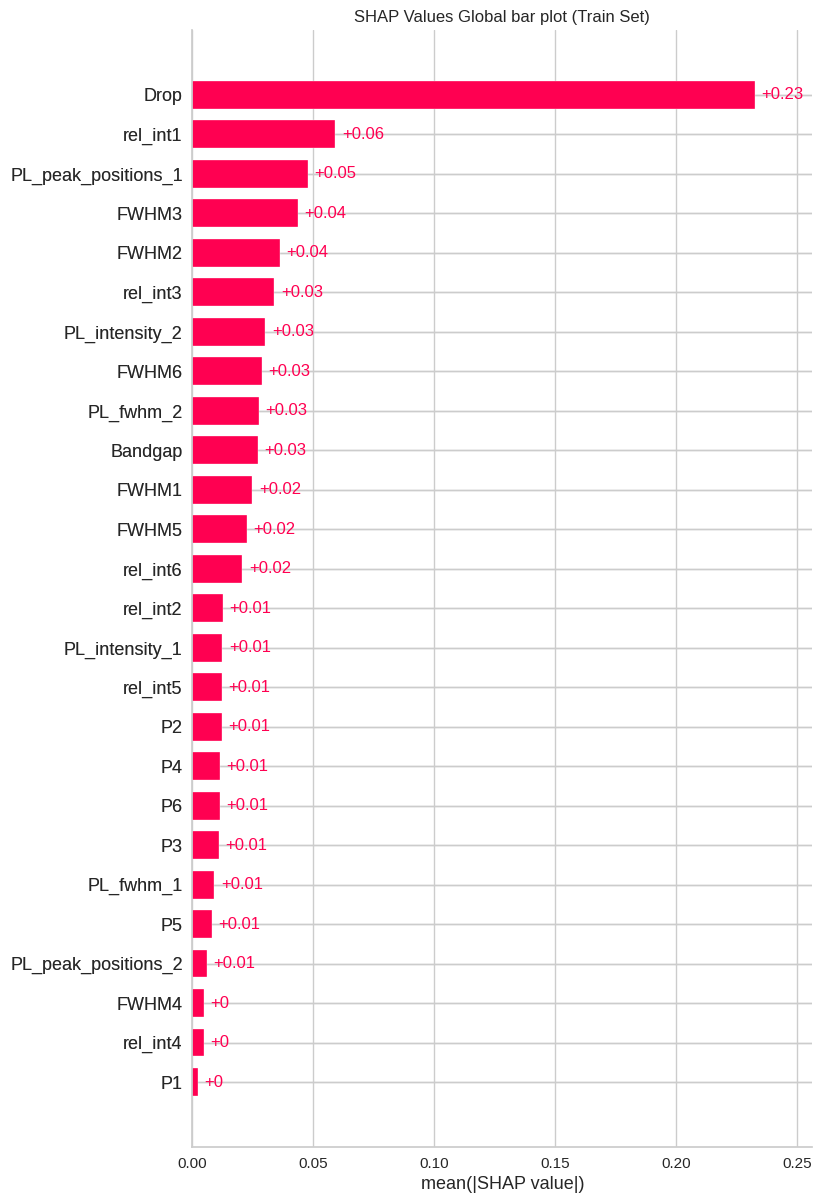

In [ ]:
shap_values = plot_shap_values(best_model, X, X_train, X_test)

##GBR Bayesian optimization

In [ ]:
#  the objective function for Bayesian optimization (GBR)
def gbr_evaluate(n_estimators, learning_rate, max_depth, subsample, alpha):
    model = GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        alpha=alpha,  # Regularization parameter
        random_state=0
    )
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return -rmse_test

# Define the parameter search space for GBR
gbr_search_space = {
    'n_estimators': (50, 100),
    'learning_rate': (0.01, 1.0),
    'max_depth': (2, 10),
    'subsample': (0.5, 1.0),
    'alpha': (0.01, 0.1)  # Regularization parameter (L1 and L2)
}

# Perform Bayesian optimization for GBR
optimizer = BayesianOptimization(
    f=gbr_evaluate,
    pbounds=gbr_search_space,
    random_state=0
)

optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters for GBR
gbr_best_params = optimizer.max['params']
gbr_best_params['n_estimators'] = int(gbr_best_params['n_estimators'])
gbr_best_params['max_depth'] = int(gbr_best_params['max_depth'])


# Train the GBR model with the best hyperparameters
gbr_best_model = GradientBoostingRegressor(**gbr_best_params, random_state=0)
gbr_best_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(gbr_best_model, X_train, y_train, cv=5, scoring='r2')

# Make predictions on the training and testing sets
y_pred_train = gbr_best_model.predict(X_train)
y_pred_test = gbr_best_model.predict(X_test)

# Calculate R2 scores
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)



# Results
GBR = pd.DataFrame({
    'R-squared Score (Test Set)': [r2_test],
    'R-squared Score (Train Set)': [r2_train],

    'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
    'MAE (Test Set)': [mean_absolute_error(y_test, y_pred_test)],
    'MAE (Train Set)': [mean_absolute_error(y_train, y_pred_train)],
    'Explained Variance Score (Test Set)': [explained_variance_score(y_test, y_pred_test)],
    'Explained Variance Score (Train Set)': [explained_variance_score(y_train, y_pred_train)],
    'Max Error (Test Set)': [max_error(y_test, y_pred_test)],
    'Max Error (Train Set)': [max_error(y_train, y_pred_train)],
    'Best max_depth': [gbr_best_params['max_depth']],
    'Best learning_rate': [gbr_best_params['learning_rate']],
    'Best n_estimators': [gbr_best_params['n_estimators']],
    'Best subsample': [gbr_best_params['subsample']],
    'Best alpha': [gbr_best_params['alpha']],
    'Cross-Validation Mean R2': [np.mean(cv_scores)],
    'Cross-Validation Std R2': [np.std(cv_scores)]
}, index=['GradientBoostingRegressor-BayesianOptimization'])



# Print individual CV scores
print("\nCross-Validation R2 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

GBR

|   iter    |  target   |   alpha   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.3648   | 0.05939   | 0.718     | 6.822     | 77.24     | 0.7118    |
| 2         | -0.4153   | 0.06813   | 0.4432    | 9.134     | 98.18     | 0.6917    |
| 3         | -0.3644   | 0.08126   | 0.5336    | 6.544     | 96.28     | 0.5355    |
| 4         | -0.1906   | 0.01784   | 0.03002   | 8.661     | 88.91     | 0.935     |
| 5         | -0.4208   | 0.09808   | 0.8012    | 5.692     | 89.03     | 0.5591    |
| 6         | -0.2147   | 0.01912   | 0.01622   | 8.632     | 88.93     | 0.9475    |
| 7         | -0.53     | 0.09754   | 0.9905    | 7.087     | 57.65     | 0.6576    |
| 8         | -0.2127   | 0.1       | 0.1846    | 8.844     | 88.87     | 0.9583    |
| 9         | -0.3659   | 0.01      | 0.01      | 8.763     | 88.66     | 0.7224    |
| 10        | -0.3548   | 0.05534   | 0.3924    | 8.86

,R-squared Score (Test Set),R-squared Score (Train Set),RMSE (Test Set),RMSE (Train Set),MAE (Test Set),MAE (Train Set),Explained Variance Score (Test Set),Explained Variance Score (Train Set),Max Error (Test Set),Max Error (Train Set),Best max_depth,Best learning_rate,Best n_estimators,Best subsample,Best alpha,Cross-Validation Mean R2,Cross-Validation Std R2
GradientBoostingRegressor-BayesianOptimization,0.928014,0.993192,0.190619,0.056835,0.162804,0.046465,0.938277,0.9932,0.326047,0.108186,8,0.030016,88,0.935006,0.017842,-1.080587,2.115103


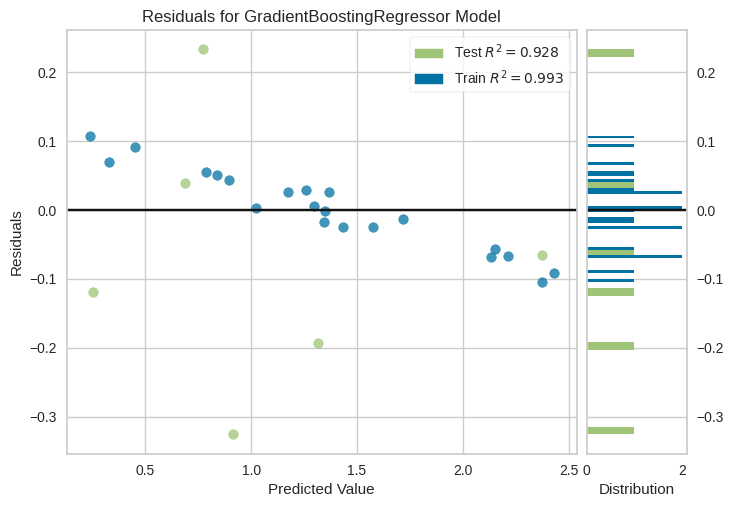

In [ ]:
visualizer = ResidualsPlot(gbr_best_model)
visualizer.score(X_test,y_test)
visualizer.fit(X_train,y_train)
visualizer.show()
plt.show()

In [ ]:
get_feature_importances(gbr_best_model, X)

,Feature,Importance
0,Drop,0.411772
1,PL_fwhm_2,0.085400
2,FWHM1,0.067591
3,PL_intensity_2,0.052977
4,FWHM6,0.048139
5,PL_peak_positions_1,0.042022
6,FWHM4,0.041281
7,FWHM5,0.039734
8,FWHM2,0.034976
9,rel_int1,0.033841


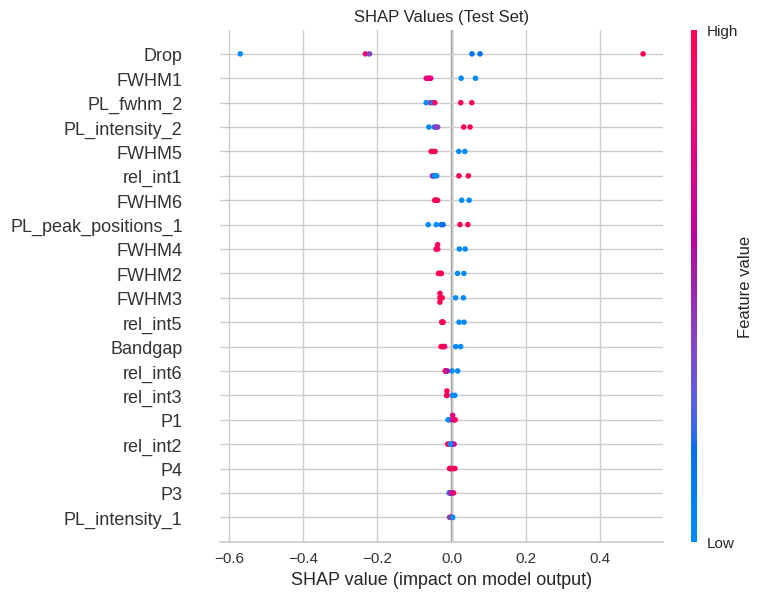

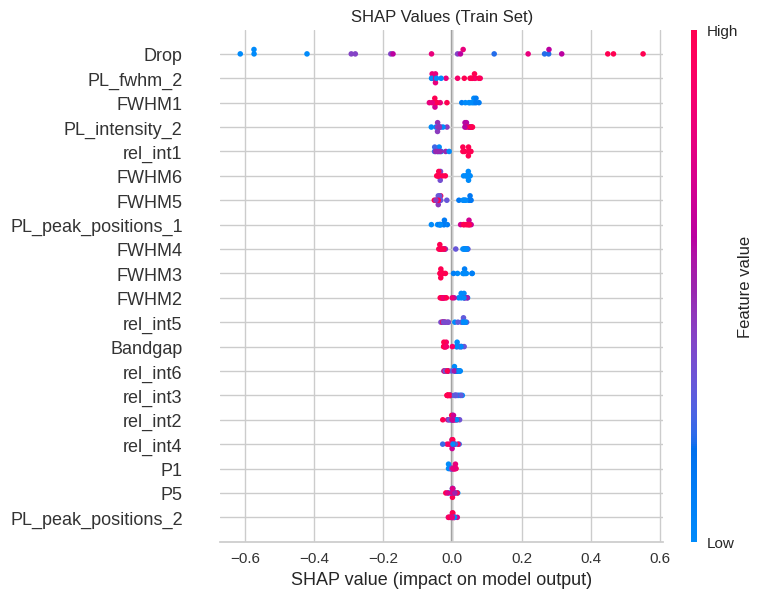

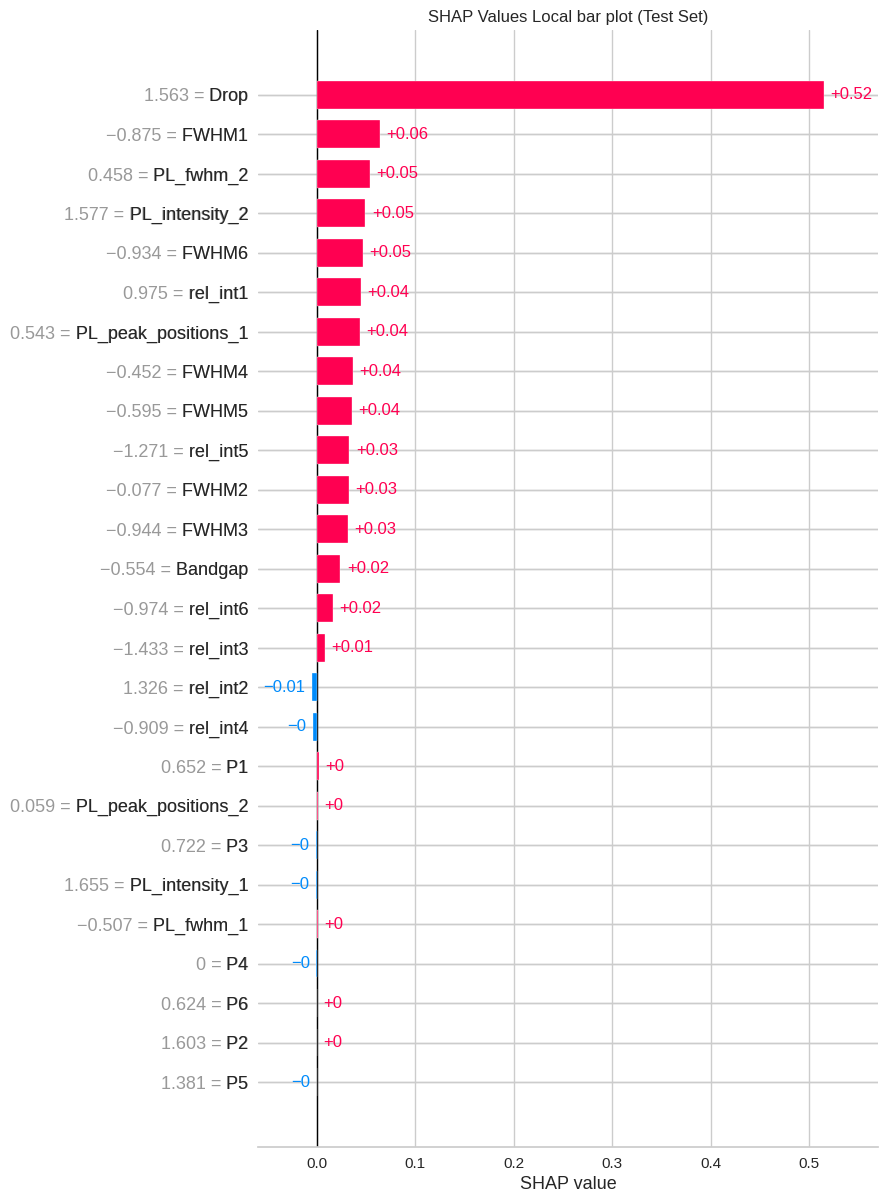

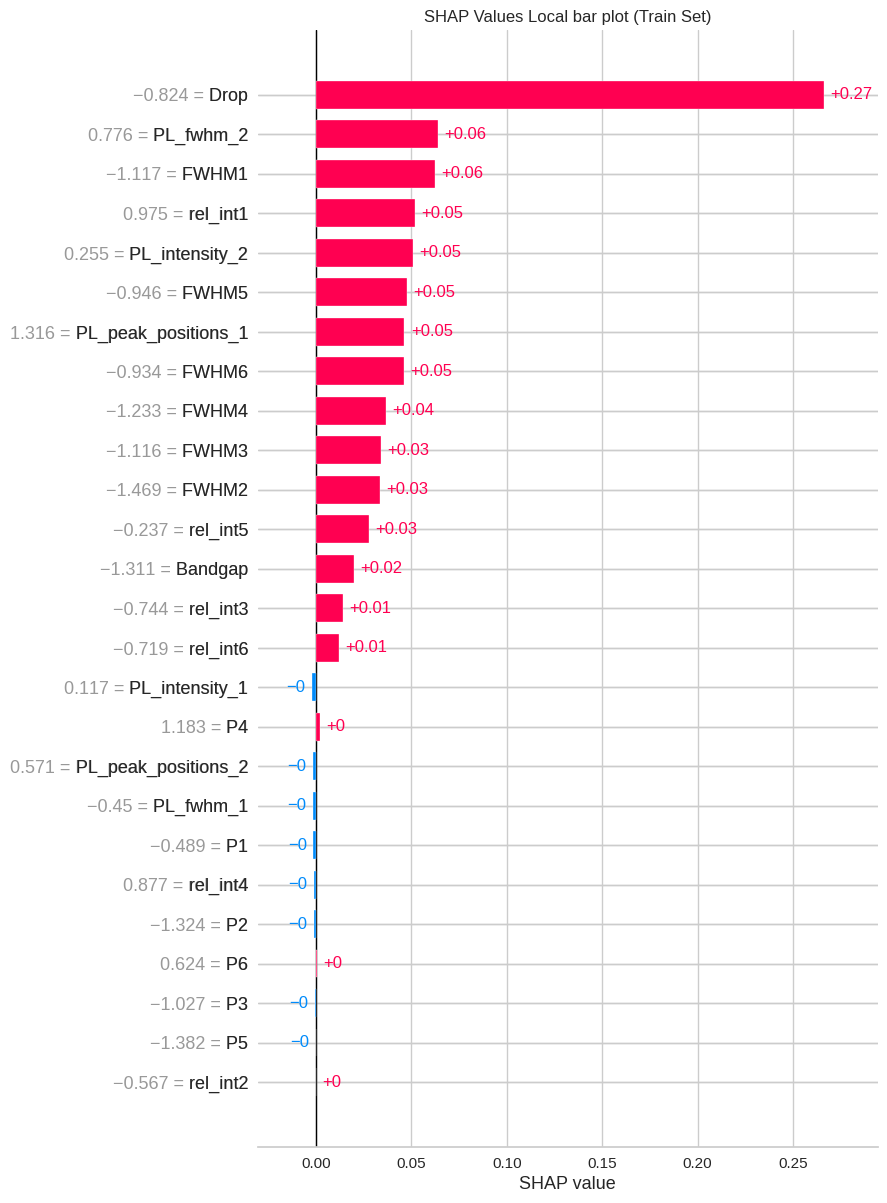

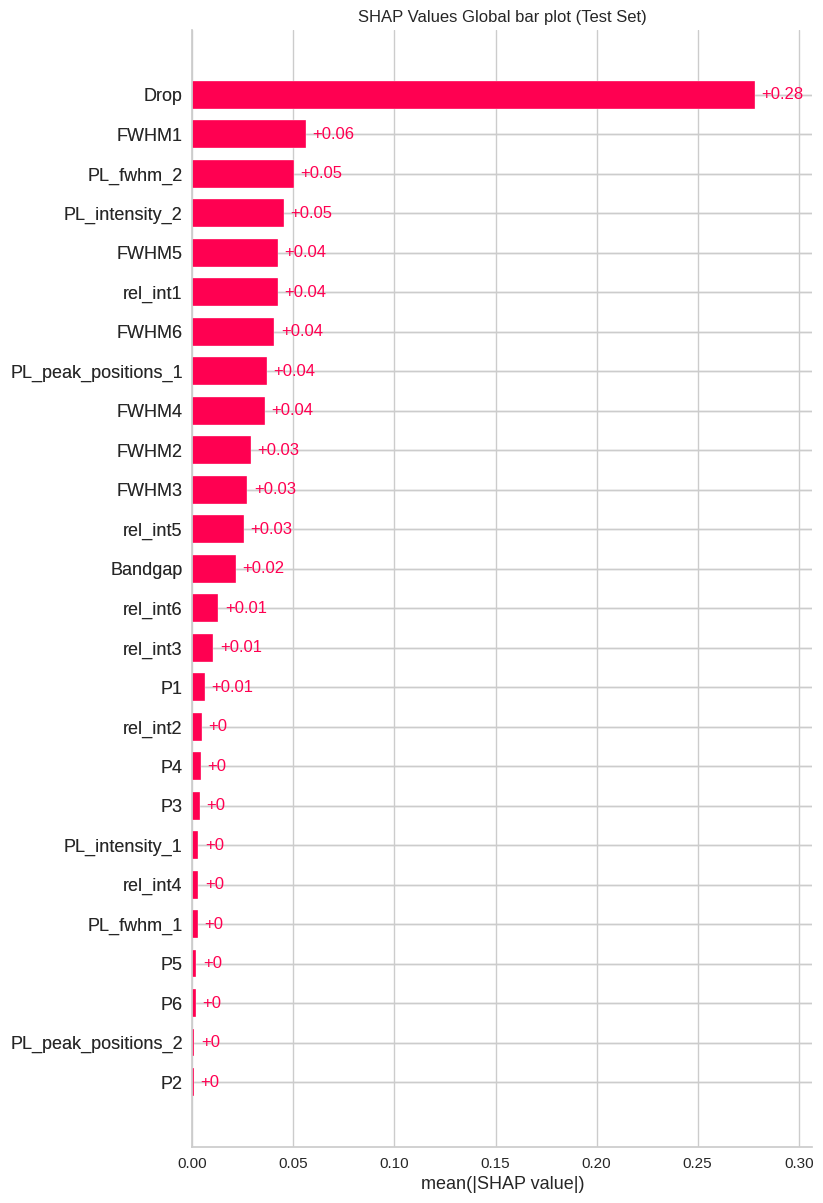

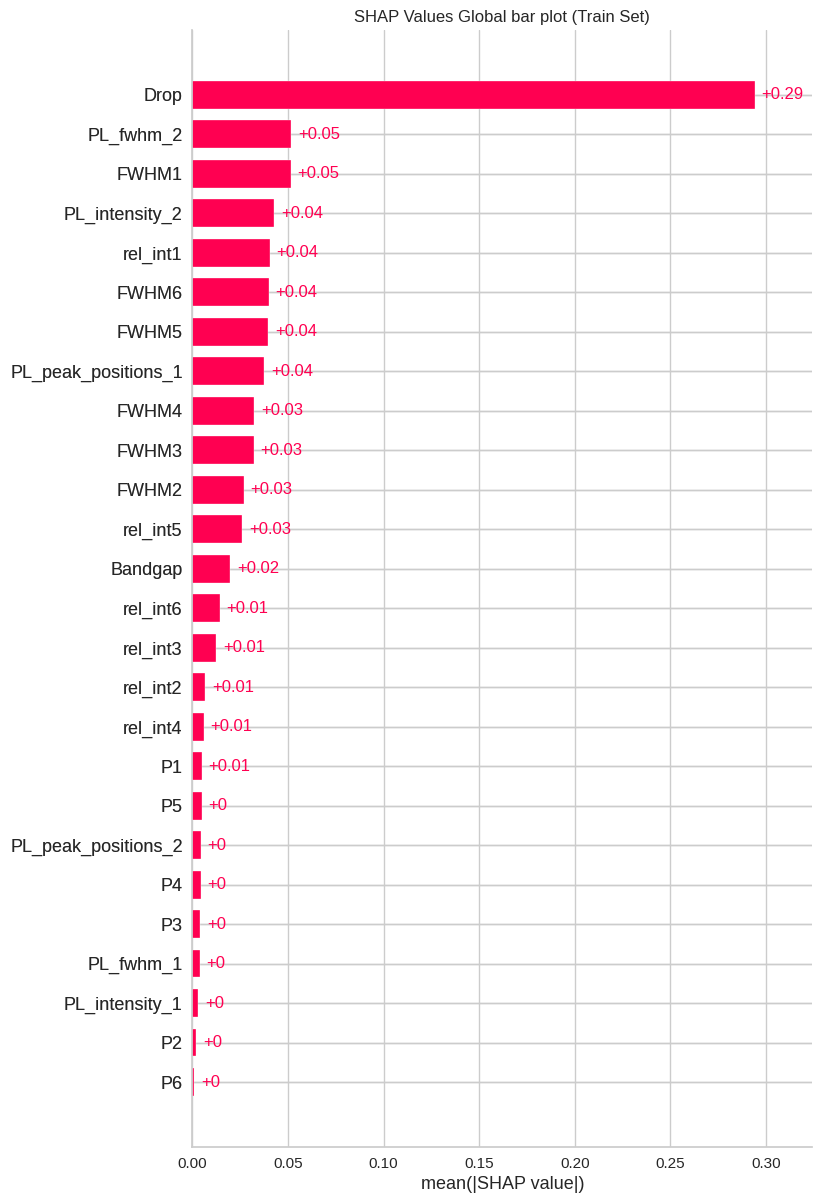

In [ ]:
plot_shap_values(gbr_best_model, X,X_train, X_test)

##Cv

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6703939	total: 6.05ms	remaining: 1.2s
5:	learn: 0.6656323	total: 6.85ms	remaining: 1.13s
6:	learn: 0.6607240	total: 7.69ms	remaining: 1.09s
7:	learn: 0.6560191	total: 8.57ms	remaining: 1.06s
8:	learn: 0.6515048	total: 9.36ms	remaining: 1.03s
9:	learn: 0.6460838	total: 10.2ms	remaining: 1.01s
10:	learn: 0.6420480	total: 10.9ms	remaining: 982ms
11:	learn: 0.6373456	total: 12.1ms	remaining: 994ms
12:	learn: 0.6322084	total: 13ms	remaining: 986ms
13:	learn: 0.6283809	total: 13.7ms	remaining: 962ms
14:	learn: 0.6238750	total: 14.4ms	remaining: 947ms
15:	learn: 0.6190494	total: 15ms	remaining: 925ms
16:	learn: 0.6154485	total: 15.6ms	remaining: 901ms
17:	learn: 0.6112155	total: 16.2ms	remaining: 884ms
18:	learn: 0.6070361	total: 16.8ms	remaining: 867ms
19:	learn: 0.6036461	total: 17.7ms	remaining: 869ms
20:	learn: 0.5996641	total: 18.8ms	remaining: 878ms
21:	learn: 0.5964040	total: 19.6ms	remaining: 873ms
22:	learn: 0.5923023	tot

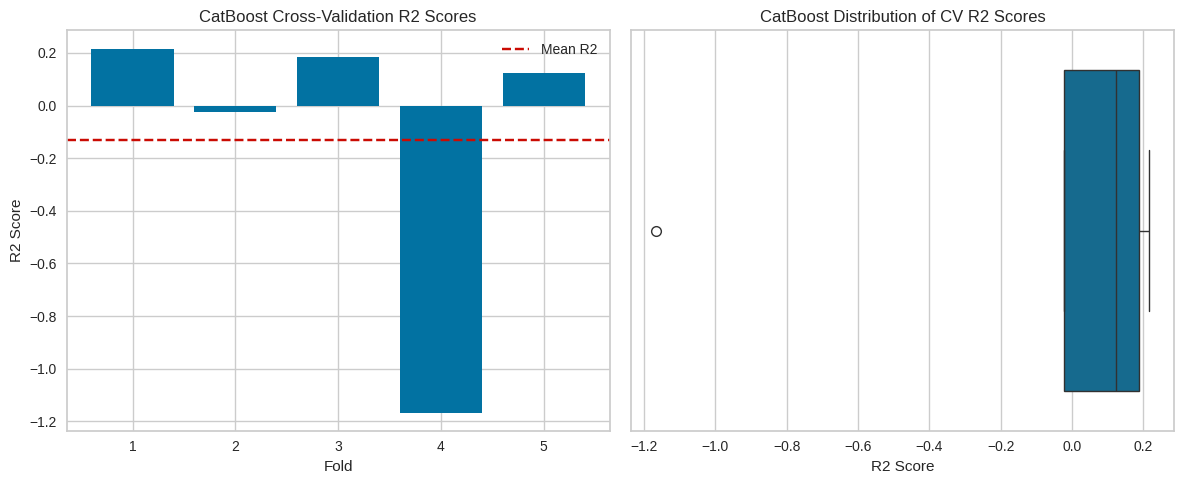


CatBoost Cross-Validation R2 Scores Summary:
Mean: -0.1326
Median: 0.1235
Std Dev: 0.5235
Min: -1.1666
Max: 0.2165


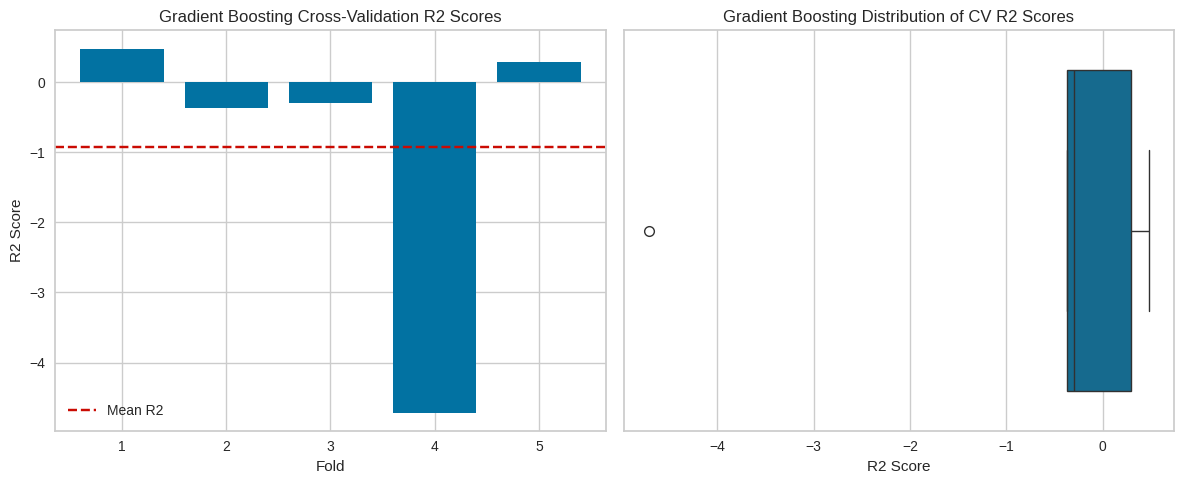


Gradient Boosting Cross-Validation R2 Scores Summary:
Mean: -0.9228
Median: -0.2966
Std Dev: 1.9233
Min: -4.7128
Max: 0.4786


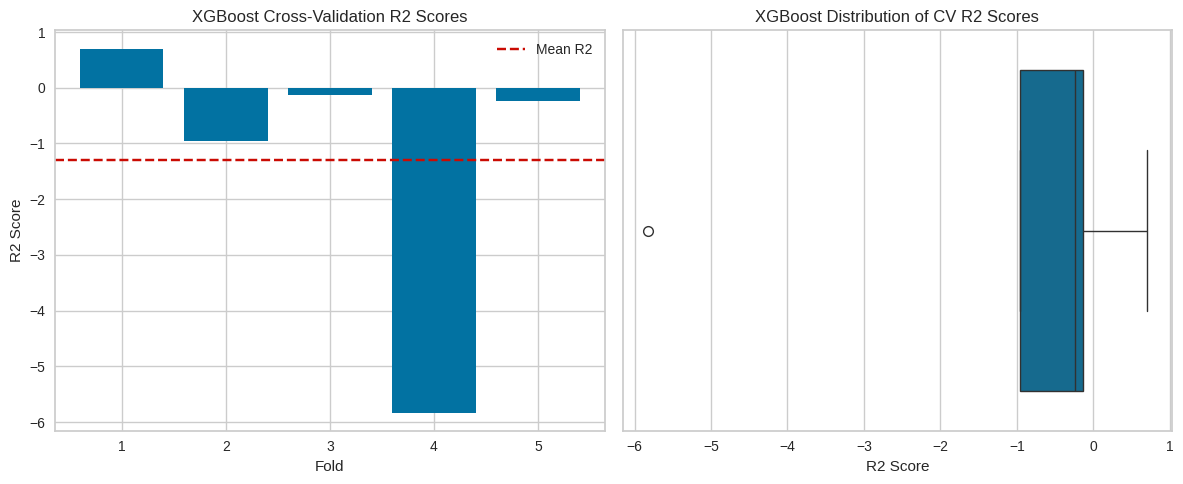


XGBoost Cross-Validation R2 Scores Summary:
Mean: -1.2916
Median: -0.2412
Std Dev: 2.3294
Min: -5.8290
Max: 0.7034

Final Results:


,R-squared Score (Test Set),R-squared Score (Train Set),Adjusted R-squared Score (Test Set),Adjusted R-squared Score (Train Set),Cross-Validation R2 (Mean),Cross-Validation R2 (Std),RMSE (Test Set),RMSE (Train Set),MAE (Test Set),MAE (Train Set),Explained Variance Score (Test Set),Explained Variance Score (Train Set),Max Error (Test Set),Max Error (Train Set)
CatBoost,0.714949,0.999768,1.067869,1.000774,-0.132620,0.523522,0.379318,0.010499,0.278396,0.008911,0.724964,0.999768,0.779452,0.017305
Gradient Boosting,0.784786,0.985476,1.051241,1.048413,-0.922765,1.923308,0.329592,0.083011,0.304439,0.059474,0.908058,0.985476,0.507646,0.162750
XGBoost,0.824810,0.999941,1.041712,1.000197,-1.291550,2.329450,0.297369,0.005289,0.242429,0.003178,0.888405,0.999941,0.575808,0.012669


In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Predictions on the test set and train set
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Calculate R2 scores
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    # Calculate Adjusted R2 scores
    def adjusted_r2(r2, n, p):
        return 1 - (((1 - r2) * (n - 1)) / (n - p - 1))

    n_test = len(y_test)
    n_train = len(y_train)
    p = X_train.shape[1]  # number of features
    adj_r2_test = adjusted_r2(r2_test, n_test, p)
    adj_r2_train = adjusted_r2(r2_train, n_train, p)

    # Results DataFrame
    res = pd.DataFrame({
        'R-squared Score (Test Set)': [r2_test],
        'R-squared Score (Train Set)': [r2_train],
        'Adjusted R-squared Score (Test Set)': [adj_r2_test],
        'Adjusted R-squared Score (Train Set)': [adj_r2_train],
        'Cross-Validation R2 (Mean)': [cv_scores.mean()],
        'Cross-Validation R2 (Std)': [cv_scores.std()],
        'RMSE (Test Set)': [np.sqrt(mean_squared_error(y_test, y_pred_test))],
        'RMSE (Train Set)': [np.sqrt(mean_squared_error(y_train, y_pred_train))],
        'MAE (Test Set)': [mean_absolute_error(y_test, y_pred_test)],
        'MAE (Train Set)': [mean_absolute_error(y_train, y_pred_train)],
        'Explained Variance Score (Test Set)': [explained_variance_score(y_test, y_pred_test)],
        'Explained Variance Score (Train Set)': [explained_variance_score(y_train, y_pred_train)],
        'Max Error (Test Set)': [max_error(y_test, y_pred_test)],
        'Max Error (Train Set)': [max_error(y_train, y_pred_train)]
    }, index=[model_name])

    # Visualize CV scores
    plt.figure(figsize=(12, 5))

    # Bar plot
    plt.subplot(121)
    plt.bar(range(1, len(cv_scores) + 1), cv_scores)
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label='Mean R2')
    plt.xlabel('Fold')
    plt.ylabel('R2 Score')
    plt.title(f'{model_name} Cross-Validation R2 Scores')
    plt.legend()

    # Box plot
    plt.subplot(122)
    sns.boxplot(x=cv_scores)
    plt.xlabel('R2 Score')
    plt.title(f'{model_name} Distribution of CV R2 Scores')

    plt.tight_layout()
    plt.show()

    #  summary statistics of CV scores
    print(f"\n{model_name} Cross-Validation R2 Scores Summary:")
    print(f"Mean: {cv_scores.mean():.4f}")
    print(f"Median: {np.median(cv_scores):.4f}")
    print(f"Std Dev: {cv_scores.std():.4f}")
    print(f"Min: {cv_scores.min():.4f}")
    print(f"Max: {cv_scores.max():.4f}")

    return res

models = [
    (CatBoostRegressor(), "CatBoost"),
    (GradientBoostingRegressor(), "Gradient Boosting"),
    (XGBRegressor(), "XGBoost")
]

results = pd.DataFrame()

for model, name in models:
    res = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results = pd.concat([results, res])

# Display final results
print("\nFinal Results:")
(results)